In [1]:
import json
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print(f"Environment: {sys.executable}")

Environment: /n/groups/datta/tim_sainburg/conda_envs/mmdeploy/bin/python


In [2]:
# model_directory = Path("/n/groups/datta/tim_sainburg/datasets/scratch/mm_training/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-08-15-10-35-59/")
model_directory = Path(
    "/n/groups/datta/6cam_keypoint_networks/mm_pose/Jonah/20241030_v1/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-10-31-12-48-26"
)

In [3]:
!ls {model_directory}

20241031_125014  epoch_30.pth  epoch_45.pth  epoch_60.pth
config.py	 epoch_33.pth  epoch_48.pth  epoch_63.pth
epoch_21.pth	 epoch_36.pth  epoch_51.pth  last_checkpoint
epoch_24.pth	 epoch_39.pth  epoch_54.pth  rtmdet_s_8xb32-300e_coco.py
epoch_27.pth	 epoch_42.pth  epoch_57.pth


In [4]:
config_loc = model_directory / "config.py"
checkpoint_loc = config_loc.parent / "epoch_60.pth"

In [5]:
log_file = np.sort(list(model_directory.glob("*/*.log")))[-1]
with open(log_file, "r") as file:
    log_info = file.read()
loss_lines = [i for i in log_info.split("\n") if " loss: " in i]
loss = [float(i.split("  loss: ")[1].split("  loss_cls:")[0]) for i in loss_lines]

Text(0, 0.5, 'Training Loss')

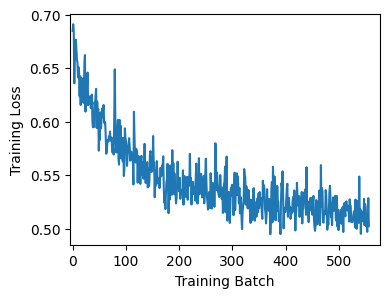

In [6]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(np.arange(len(loss[20:])), loss[20:])
ax.set_xlim([-5, len(loss)])
ax.set_xlabel("Training Batch")
ax.set_ylabel("Training Loss")

### Load the inferencer

In [7]:
from mmdet.apis import DetInferencer

/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# Choose to use a config
config = config_loc.as_posix()
# Setup a checkpoint file to load
checkpoint = checkpoint_loc.as_posix()
# Set the device to be used for evaluation
device = "cuda:0"

In [9]:
# Initialize the DetInferencer
inferencer = DetInferencer(config, checkpoint, device, show_progress=False)

Loads checkpoint by local backend from path: /n/groups/datta/6cam_keypoint_networks/mm_pose/Jonah/20241030_v1/rtmdet/rtmdet_small_8xb32-300e_coco_chronic_24-10-31-12-48-26/epoch_60.pth
11/01 10:12:40 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


/n/groups/datta/tim_sainburg/conda_envs/mmdeploy/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


(0.0, 10.0)

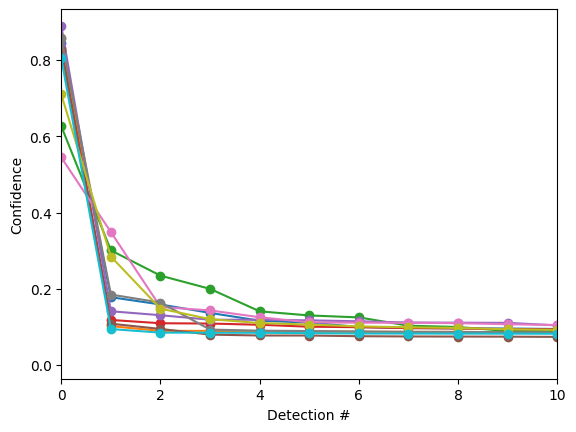

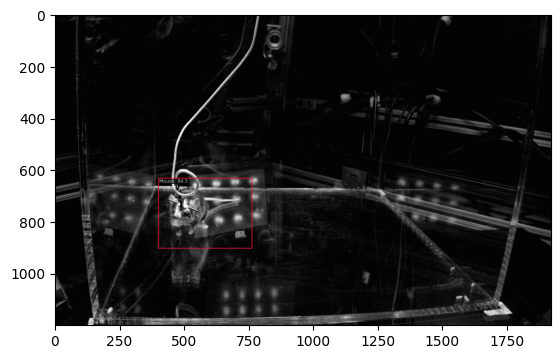

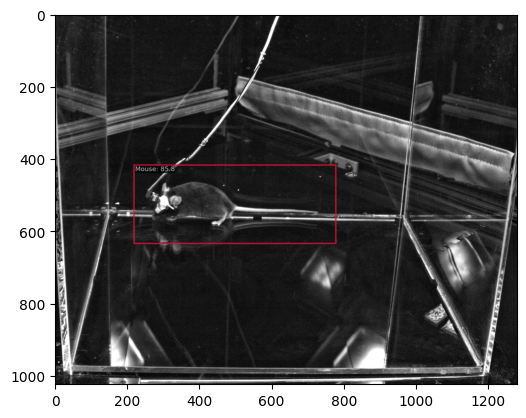

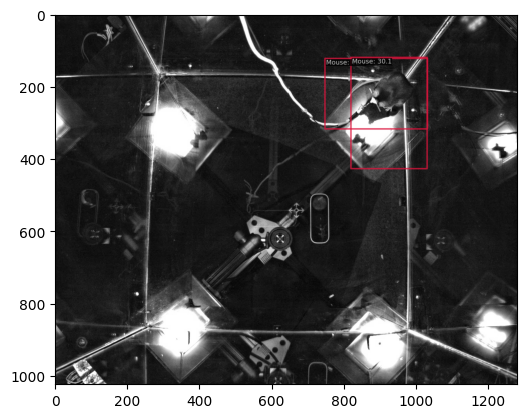

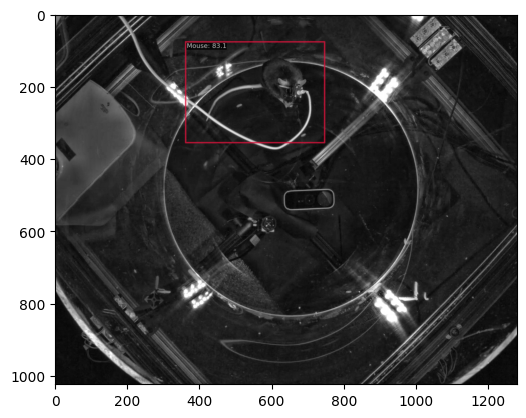

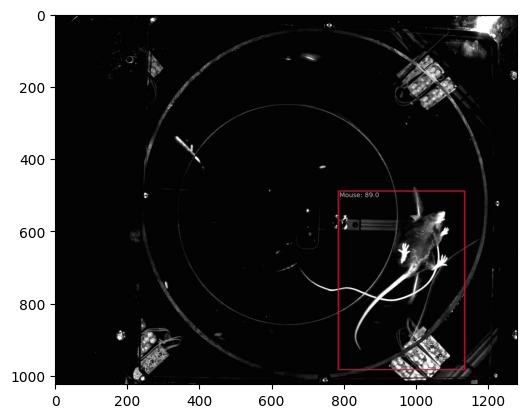

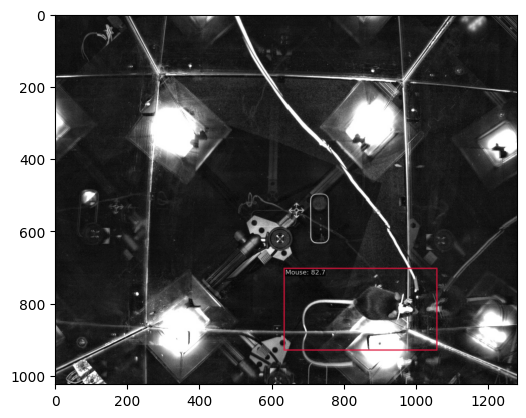

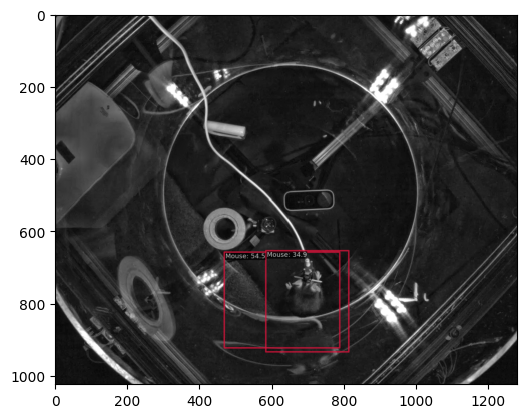

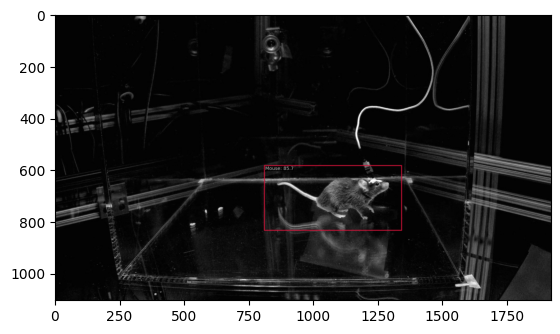

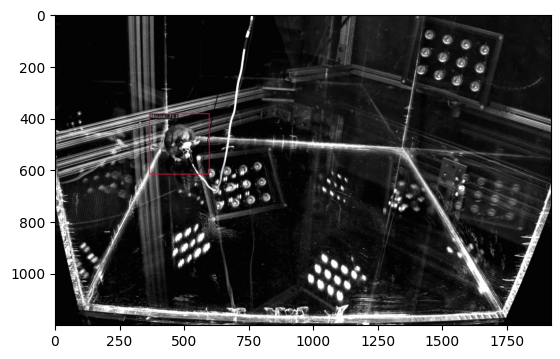

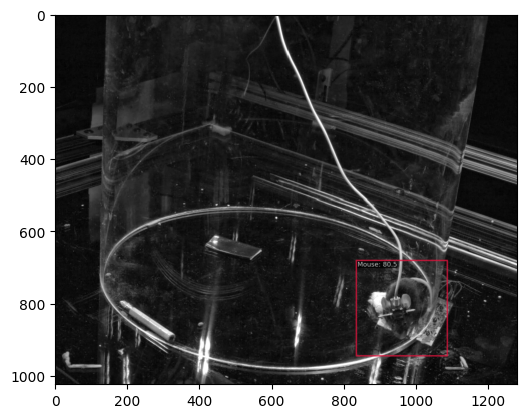

In [13]:
# load a test image
val_dict_path = "/n/groups/datta/6cam_keypoint_networks/training_data/JP_CW_scale_annos/COCO_format/annotations/instances_val.json"
n_val_imgs = 10

with open(val_dict_path, "r") as file:
    val_dict = json.load(file)
all_val_imgs = [i["file_path"] for i in val_dict["images"]]
val_imgs = np.random.choice(all_val_imgs, n_val_imgs)

conf_fig, conf_ax = plt.subplots(1, 1)
for img in val_imgs:
    image = Image.open(img)
    image_array = np.array(image)
    result = inferencer(image_array, out_dir="/tmp", pred_score_thr=0.3)
    conf_ax.plot(result["predictions"][0]["scores"], "-o")
    plt.figure()
    plt.imshow(result["visualization"][0])

conf_ax.set_xlabel("Detection #")
conf_ax.set_ylabel("Confidence")
conf_ax.set_xlim([0, 10])